In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from glob import glob
import statistics
import os
import pandas as pd
from scipy import stats

### CCH5000

Incremental Accuracy (Table 1 & Figure 4)

Incremental class per step: 1
	 iCaRL: Ttest_relResult(statistic=5.908282050414756, pvalue=0.027471898667512137)
	 UCIR: Ttest_relResult(statistic=6.265948509734467, pvalue=0.02453632452697603)
	 PODNet: Ttest_relResult(statistic=8.052983802561068, pvalue=0.01507232801078652)
	 DER: Ttest_relResult(statistic=7.2581415848725115, pvalue=0.018458370997924356)
Incremental class per step: 2
	 iCaRL: Ttest_relResult(statistic=5.875986400102005, pvalue=0.027762217115891028)
	 UCIR: Ttest_relResult(statistic=9.29122828677217, pvalue=0.011386401379972709)
	 PODNet: Ttest_relResult(statistic=6.645910061026542, pvalue=0.021899767618453324)
	 DER: Ttest_relResult(statistic=8.219949365267654, pvalue=0.014479340018196358)


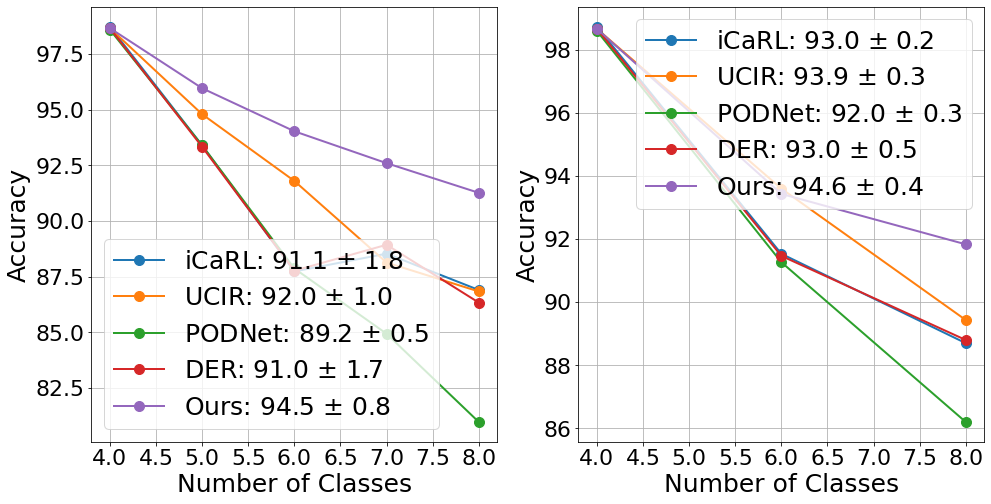

In [2]:
folder = f'results/pretrain'
exps = {
    1:
       {
        'iCaRL': f'{folder}/icarl/20220728_icarl_colorectal_4steps1',
        'UCIR': f'{folder}/ucir/20220728_ucir_colorectal_4steps1',
        'PODNet': f'{folder}/podnet/20220728_podnet_colorectal_4steps1',
        'DER': f'{folder}/der/20220728_derE0_colorectal_4steps1',
        'Ours': f'{folder}/ours/20220731_derE3_colorectal_4steps1',
       },
    2:
       {
        'iCaRL': f'{folder}/icarl/20220728_icarl_colorectal_4steps2',
        'UCIR': f'{folder}/ucir/20220728_ucir_colorectal_4steps2',
        'PODNet': f'{folder}/podnet/20220728_podnet_colorectal_4steps2',
        'DER': f'{folder}/der/20220728_derE0_colorectal_4steps2',
        'Ours': f'{folder}/ours/20220731_derE3_colorectal_4steps2',
       }       
      }

incs=[1,2]
row = min(len(incs),3)
plt.figure(figsize=(8*len(incs),8))
for j, inc in enumerate(incs):
    print(f'Incremental class per step: {inc}')
    exp = exps[inc]
    plt.subplot(int(np.ceil(len(incs)//row)),row,j+1)

    avg_top1_total = {}
    cul_top1_total = {}
    count = {}
    for k in [0,1,2]:
        for e1, e2 in exp.items():
            file = f'{e2}/run_{k}_1993_.json'
            if not os.path.exists(file):
                continue
            result = json.load(open(file))

            top1_total = list(map(lambda x: 100 * x['accuracy']['total'], result['results']))
        
            if e1 in avg_top1_total:
                avg_top1_total[e1] += np.array(top1_total)
                cul_top1_total[e1].append(np.mean(top1_total))
                count[e1] += 1
            else:
                avg_top1_total[e1] = np.array(top1_total)
                cul_top1_total[e1] = [np.mean(top1_total)]
                count[e1] = 1
        
    for e1, e2 in avg_top1_total.items():
        top1_total = e2/count[e1]
        mean = statistics.mean(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else cul_top1_total[e1][0]
        std = statistics.stdev(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else 0
        if e1 != 'Ours':
            print(f"\t {e1}: {stats.ttest_rel(cul_top1_total['Ours'], cul_top1_total[e1])}")
        xs = list(range(4,9,inc))
        plt.plot(xs, top1_total, marker='o', label=f'{e1}: {mean:.1f}' + r' $\pm$ ' + f'{std:.1f}', linewidth=2, markersize=10)

    # plt.plot(xs, test)

    plt.xlabel('Number of Classes', fontsize=25)
    plt.xticks(fontsize=22)
    plt.ylabel('Accuracy', fontsize=25)
    plt.yticks(fontsize=22)
#     plt.ylim(71,89)
#     plt.title(f'{inc} new classes per step', fontsize=25)
    plt.grid(True)
    plt.legend(prop={'size':25})
#     plt.tight_layout()

plt.show()


Forgetting (Table 1 & Figure 4)

Incremental class per step: 1
	 iCaRL: Ttest_relResult(statistic=-6.234133831189526, pvalue=0.024778141241935614)
	 UCIR: Ttest_relResult(statistic=-2.9484531333340294, pvalue=0.09835243847706714)
	 PODNet: Ttest_relResult(statistic=-1.2995953876958612, pvalue=0.323361220323122)
	 DER: Ttest_relResult(statistic=-2.4353375777033284, pvalue=0.13523365646240848)
Incremental class per step: 2
	 iCaRL: Ttest_relResult(statistic=-12.69182706417014, pvalue=0.006150782807094933)
	 UCIR: Ttest_relResult(statistic=-1.0397066299035906, pvalue=0.4076673423117677)
	 PODNet: Ttest_relResult(statistic=-1.8523168449905152, pvalue=0.20517362795500907)
	 DER: Ttest_relResult(statistic=-5.764674747726104, pvalue=0.028798384386443682)


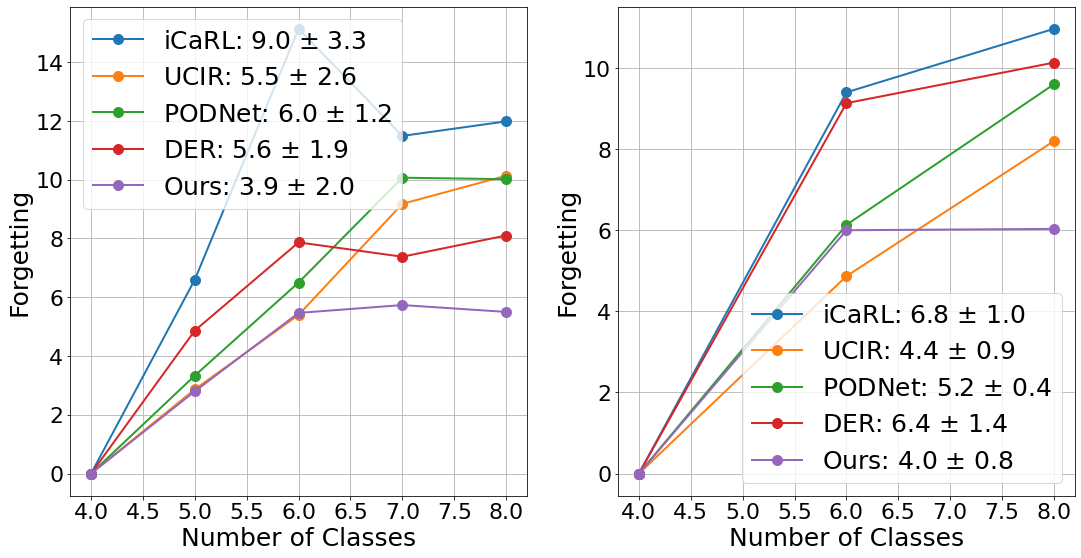

In [3]:
folder = f'results/pretrain'
exps = {
    1:
       {
        'iCaRL': f'{folder}/icarl/20220728_icarl_colorectal_4steps1',
        'UCIR': f'{folder}/ucir/20220728_ucir_colorectal_4steps1',
        'PODNet': f'{folder}/podnet/20220728_podnet_colorectal_4steps1',
        'DER': f'{folder}/der/20220728_derE0_colorectal_4steps1',
        'Ours': f'{folder}/ours/20220731_derE3_colorectal_4steps1',
       },
    2:
       {
        'iCaRL': f'{folder}/icarl/20220728_icarl_colorectal_4steps2',
        'UCIR': f'{folder}/ucir/20220728_ucir_colorectal_4steps2',
        'PODNet': f'{folder}/podnet/20220728_podnet_colorectal_4steps2',
        'DER': f'{folder}/der/20220728_derE0_colorectal_4steps2',
        'Ours': f'{folder}/ours/20220731_derE3_colorectal_4steps2',
       }       
      }

incs=[1,2]
row = min(len(incs),3)
plt.figure(figsize=(9*len(incs),9))
for j, inc in enumerate(incs):
    print(f'Incremental class per step: {inc}')
    exp = exps[inc]
    step = int(4//inc)

    plt.subplot(int(np.ceil(len(incs)//row)),row,j+1)

    all_forget = {}
    avg_forget = {}
    count = {}
    for j in [0,1,2]:
        for e1, e2 in exp.items():
            file = f'{e2}/run_{j}_1993_.json'
            if not os.path.exists(file):
                continue
            result = json.load(open(file))
            
            all_forget_total = {}
            for k in range(step,step*2+1):
                if k == step:
                    start = 0
                else:
                    start = (k-1)*inc
                end = k*inc - 1

                top1_first = np.zeros(len(result['results']) - (k-step))
                for p in range(start, end+1):
                    new_key = f'{str(p).zfill(2)}-{str(p).zfill(2)}'
                    top1_first += np.array(list(map(lambda x: x['accuracy_per_class'][new_key], result['results'][(k-step):])))
                top1_first /= (end-start+1) / 100

                forgetting = np.concatenate([[0], np.maximum.accumulate(top1_first)[:-1] - top1_first[1:]])

                if e1 in all_forget_total:
                    all_forget_total[e1][k-step:] += np.array(forgetting)
                else:
                    all_forget_total[e1] = np.array(forgetting)
                    
            forgetting = all_forget_total[e1]        
            forgetting[1:] /= np.arange(len(forgetting)-1) + 1
            if e1 in all_forget:
                all_forget[e1] += forgetting
                avg_forget[e1].append(np.mean(forgetting))
                count[e1] += 1
            else:
                all_forget[e1] = forgetting
                avg_forget[e1] = [np.mean(forgetting)]
                count[e1] = 1
            
    for e1, e2 in all_forget.items():
        forgetting = all_forget[e1]/count[e1]
        mean = statistics.mean(avg_forget[e1]) if len(avg_forget[e1])>1 else avg_forget[e1][0]
        std = statistics.stdev(avg_forget[e1]) if len(avg_forget[e1])>1 else 0
        if e1 != 'Ours':
            print(f"\t {e1}: {stats.ttest_rel(avg_forget['Ours'], avg_forget[e1])}")
        xs = list(range(4,9,inc))
        plt.plot(xs, forgetting, marker='o', label=f'{e1}: {mean:.1f}' + r' $\pm$ ' + f'{std:.1f}', linewidth=2, markersize=10)
        
    plt.xlabel('Number of Classes', fontsize=25)
    plt.xticks(fontsize=22)
    plt.ylabel('Forgetting', fontsize=25)
    plt.yticks(fontsize=22)
    plt.grid(True)
#     plt.ylim(-1,15)
#     plt.title(f'{inc} new classes per step', fontsize=25)
    plt.legend(prop={'size':25})
#     plt.tight_layout()

plt.show()


Ablation study (Table 4)

Ours: 
  Average incremental accuracy: 94.5 ± 0.8
  Average new task accuracy: 96.6 ± 0.9
  Average first task accuracy: 94.0 ± 0.7

Without alternating loss: 
  Average incremental accuracy: 93.8 ± 1.1
  Average new task accuracy: 97.9 ± 1.0
  Average first task accuracy: 92.6 ± 1.1

Without auxiliary loss: 
  Average incremental accuracy: 94.4 ± 0.7
  Average new task accuracy: 96.4 ± 0.6
  Average first task accuracy: 93.7 ± 0.9

Without distillation loss: 
  Average incremental accuracy: 93.4 ± 0.4
  Average new task accuracy: 96.5 ± 0.6
  Average first task accuracy: 92.4 ± 0.6

Without margin loss: 
  Average incremental accuracy: 91.8 ± 1.7
  Average new task accuracy: 98.9 ± 0.5
  Average first task accuracy: 89.3 ± 1.5



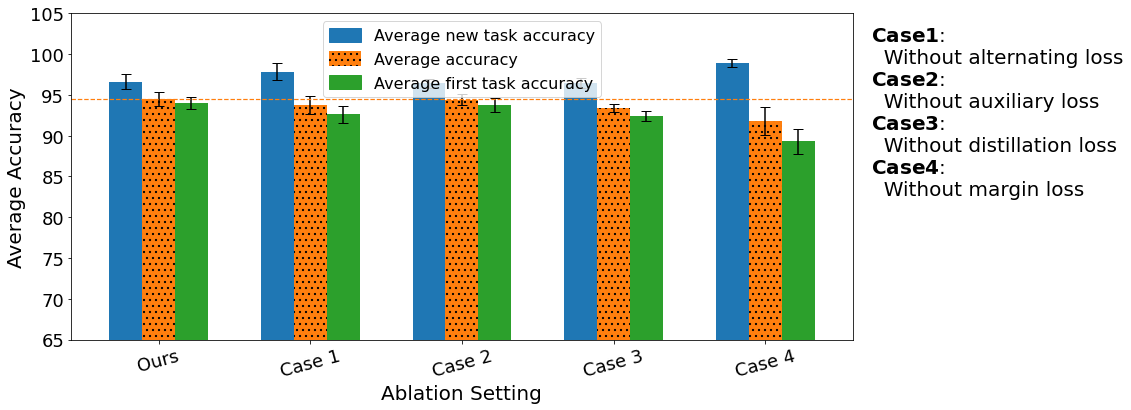

In [4]:
folder = f'results/pretrain'
exps = {
        'Ours': f'{folder}/ours/20220731_derE3_colorectal_4steps1',
        'Without alternating loss': f'{folder}/ablation/20220731_derE3_colorectal_4steps1_noAlt',
        'Without auxiliary loss': f'{folder}/ablation/20220731_derE3_colorectal_4steps1_noAux',
        'Without distillation loss': f'{folder}/ablation/20220731_derE3_colorectal_4steps1_noDis',
        'Without margin loss': f'{folder}/ablation/20220731_derE3_colorectal_4steps1_noMar',
       }

inc = 1
avg_top1_total = {}
cul_top1_total = {}
avg_top1_last = {}
avg_top1_first = {}
count = {}
for k in [0,1,2]:
    for e1, e2 in exps.items():
        file = f'{e2}/run_{k}_1993_.json'
        if not os.path.exists(file):
            continue
        result = json.load(open(file))

        top1_total = list(map(lambda x: 100 * x['accuracy']['total'], result['results']))
        top1_last = [result['results'][i]['accuracy'][f'0{4+(i-1)}-0{4+i-1}'] * 100 for i in range(1,5)]

        top1_first = np.zeros(5)
        for p in range(0,4,1):
            new_key = f'{str(p).zfill(2)}-{str(p).zfill(2)}'
            top1_first += np.array(list(map(lambda x: x['accuracy'][new_key], result['results'])))
        top1_first = top1_first / 4 * 100
        
        if e1 in avg_top1_total:
            avg_top1_total[e1] += np.array(top1_total)
            cul_top1_total[e1].append(np.mean(top1_total))
            avg_top1_last[e1].append(np.mean(top1_last))
            avg_top1_first[e1].append(np.mean(top1_first))
            count[e1] += 1
        else:
            avg_top1_total[e1] = np.array(top1_total)
            cul_top1_total[e1] = [np.mean(top1_total)]
            avg_top1_last[e1] = [np.mean(top1_last)]
            avg_top1_first[e1] = [np.mean(top1_first)]  
            count[e1] = 1

df = pd.DataFrame(columns={'Case','Setting','Incremental','New task','First task','Incremental std','New task std','First task std'})            
for i, (e1, e2) in enumerate(avg_top1_total.items()):
    top1_total = e2/count[e1]
    mean = statistics.mean(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else cul_top1_total[e1][0]
    std = statistics.stdev(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else 0
    mean_last = statistics.mean(avg_top1_last[e1]) if len(avg_top1_last[e1])>1 else avg_top1_last[e1][0]
    std_last = statistics.stdev(avg_top1_last[e1]) if len(avg_top1_last[e1])>1 else 0
    mean_first = statistics.mean(avg_top1_first[e1]) if len(avg_top1_first[e1])>1 else avg_top1_first[e1][0]
    std_first = statistics.stdev(avg_top1_first[e1]) if len(avg_top1_first[e1])>1 else 0
    xs = list(range(100,201,inc))
    title = e1.replace("\n  ",  "")
    print(f'{title}: \n  Average incremental accuracy: {mean:.1f}' + u' \u00B1 ' + f'{std:.1f}')
    print(f'  Average new task accuracy: {mean_last:.1f}' + u' \u00B1 ' + f'{std_last:.1f}')
    print(f'  Average first task accuracy: {mean_first:.1f}' + u' \u00B1 ' + f'{std_first:.1f}\n')
    df = df.append({'Case':f'Case {i}' if e1!='Ours' else e1,
                    'Setting':e1,
                    'Incremental':mean,
                    'Incremental std':std,
                    'New task':mean_last,
                    'New task std':std_last,
                    'First task':mean_first, 
                    'First task std':std_first}, 
                   ignore_index=True)

import matplotlib.patches as mpatches
ax = df.plot(x="Case", 
        y=['New task','Incremental','First task'],
        yerr=df[['New task std','Incremental std','First task std']].T.values,
        kind="bar",
        ylim=(65,105),
        rot=15,
        figsize=(14,6), 
        capsize=5,
        linewidth=0.5, 
        width=0.65,
        fontsize=18)    
for bar in ax.containers[3]:
    bar.set_hatch('..')
    
ax.set_xlabel('Ablation Setting',fontdict={'fontsize':20})
ax.set_ylabel('Average Accuracy',fontdict={'fontsize':20})
ax.legend(handles=[
    mpatches.Patch(color='#1f77b4', label='Average new task accuracy'),
    mpatches.Patch(facecolor='#ff7f0e', hatch='..', label='Average accuracy'),
    mpatches.Patch(color='#2ca02c', label='Average first task accuracy'),
], handleheight=1,fontsize=16, loc='upper center')    
plt.axhline(y=statistics.mean(cul_top1_total['Ours']), color='#ff7f0e', linestyle='--', linewidth=1.2)
txtstr = ''
for i, text in enumerate(exps.keys()):
    if i == 0:
        continue
    else:
        txtstr += '$\\bf{Case ' + str(i) + '}$' + f': \n  {text}\n'
plt.text(4.7, 80, txtstr, fontsize=20)
plt.show()

### EyePACS

Incremental Accuracy (Table 2)

Incremental class per step: 1
	 iCaRL: Ttest_relResult(statistic=6.986679532958395, pvalue=0.019877288873044838)
	 UCIR: Ttest_relResult(statistic=3.582440550943576, pvalue=0.06985296272658788)
	 PODNet: Ttest_relResult(statistic=5.003007309526371, pvalue=0.037706716249351936)
	 DER: Ttest_relResult(statistic=4.320370685082702, pvalue=0.04962069426249095)


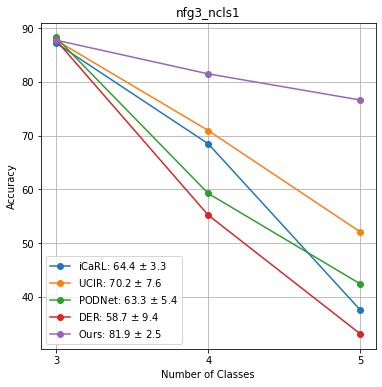

In [5]:
folder = f'results/pretrain'
exps = {
    1:
       {
        'iCaRL': f'{folder}/icarl/20220403_icarl_diabetic_3steps1',
        'UCIR': f'{folder}/ucir/20220403_ucir_diabetic_3steps1',
        'PODNet': f'{folder}/podnet/20220403_podnet_cnn_diabetic_3steps1',
        'DER': f'{folder}/der/20220404_derE0_diabetic_3steps1',
        'Ours': f'{folder}/ours/20220403_derE3_diabetic_3steps1',
       },
      }

incs=[1]
plt.figure(figsize=(6,6))

inc = 1
exp = exps[inc]

avg_top1_total = {}
cul_top1_total = {}
count = {}

print(f'Incremental class per step: {inc}')
for j in [0,1,2]:
    for e1, e2 in exp.items():
        file = f'{e2}/run_{j}_1993_.json'
        if not os.path.exists(file):
            continue
        result = json.load(open(file))

        top1_total = list(map(lambda x: 100 * x['accuracy']['total'], result['results']))

        if e1 in avg_top1_total:
            avg_top1_total[e1] += np.array(top1_total)
            cul_top1_total[e1].append(np.mean(top1_total))
            count[e1] += 1
        else:
            avg_top1_total[e1] = np.array(top1_total)
            cul_top1_total[e1] = [np.mean(top1_total)]
            count[e1] = 1
        
xs = list(range(3,6,inc))
for e1, e2 in avg_top1_total.items():
    top1_total = e2/count[e1]
    mean = statistics.mean(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else cul_top1_total[e1][0]
    std = statistics.stdev(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else 0
    if e1 != 'Ours':
        print(f"\t {e1}: {stats.ttest_rel(cul_top1_total['Ours'], cul_top1_total[e1])}")
    plt.plot(xs, top1_total, marker='o', label=f'{e1}: {mean:.1f}' + r' $\pm$ ' + f'{std:.1f}')

plt.xticks(xs)    
plt.xlabel('Number of Classes')
plt.ylabel('Accuracy')
#     plt.ylim(71,89)
plt.title(f'nfg3_ncls{inc}')
plt.grid(True)
plt.legend()
plt.show()

Forgetting (Table 2)

Incremental class per step: 1
	 iCaRL: Ttest_relResult(statistic=-6.991774035651734, pvalue=0.01984918898795747)
	 UCIR: Ttest_relResult(statistic=-2.546169969179687, pvalue=0.12579531159985632)
	 PODNet: Ttest_relResult(statistic=-7.31049371017806, pvalue=0.018202096652042428)
	 DER: Ttest_relResult(statistic=-7.158311075465789, pvalue=0.018962151559649462)


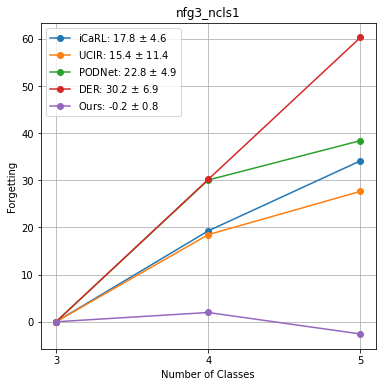

In [6]:
folder = f'results/pretrain'
exps = {
    1:
       {
        'iCaRL': f'{folder}/icarl/20220403_icarl_diabetic_3steps1',
        'UCIR': f'{folder}/ucir/20220403_ucir_diabetic_3steps1',
        'PODNet': f'{folder}/podnet/20220403_podnet_cnn_diabetic_3steps1',
        'DER': f'{folder}/der/20220404_derE0_diabetic_3steps1',
        'Ours': f'{folder}/ours/20220403_derE3_diabetic_3steps1',
       },
      }

incs=[1]
row = min(len(incs),3)
plt.figure(figsize=(6*len(incs),6))

inc = 1
exp = exps[inc]
step = int(3//inc)

all_forget = {}
avg_forget = {}
count = {}

print(f'Incremental class per step: {inc}')
for j in [0,1,2]:
    for e1, e2 in exp.items():
        file = f'{e2}/run_{j}_1993_.json'
        if not os.path.exists(file):
            continue
        result = json.load(open(file))

        all_forget_total = {}
        for k in range(step,step*2):
            if k == step:
                start = 0
            else:
                start = (k-1)*inc
            end = k*inc - 1

            top1_first = np.zeros(len(result['results']) - (k-step))
            for p in range(start, end+1):
                new_key = f'{str(p).zfill(2)}-{str(p).zfill(2)}'
                top1_first += np.array(list(map(lambda x: x['accuracy_per_class'][new_key], result['results'][(k-step):])))
            top1_first /= (end-start+1) / 100

            forgetting = np.concatenate([[0], np.maximum.accumulate(top1_first)[:-1] - top1_first[1:]])

            if e1 in all_forget_total:
                all_forget_total[e1][k-step:] += np.array(forgetting)
            else:
                all_forget_total[e1] = np.array(forgetting)

        forgetting = all_forget_total[e1]        
        forgetting[1:] /= np.arange(len(forgetting)-1) + 1
        if e1 in all_forget:
            all_forget[e1] += forgetting
            avg_forget[e1].append(np.mean(forgetting))
            count[e1] += 1
        else:
            all_forget[e1] = forgetting
            avg_forget[e1] = [np.mean(forgetting)]
            count[e1] = 1

for e1, e2 in all_forget.items():
    forgetting = all_forget[e1]/count[e1]
    mean = statistics.mean(avg_forget[e1]) if len(avg_forget[e1])>1 else avg_forget[e1][0]
    std = statistics.stdev(avg_forget[e1]) if len(avg_forget[e1])>1 else 0
    if e1 != 'Ours':
        print(f"\t {e1}: {stats.ttest_rel(avg_forget['Ours'], avg_forget[e1])}")
    xs = list(range(3,6,inc))
    plt.plot(xs, forgetting, marker='o', label=f'{e1}: {mean:.1f}' + r' $\pm$ ' + f'{std:.1f}')
        
plt.xticks(xs)    
plt.xlabel('Number of Classes')
plt.ylabel('Forgetting')
#     plt.ylim(71,89)
plt.title(f'nfg3_ncls{inc}')
plt.grid(True)
plt.legend()

plt.show()


### HAM10000

Incremental Accuracy (Table 3)

Incremental class per step: 1
	 iCaRL: Ttest_relResult(statistic=8.29608355783269, pvalue=0.014220417817187171)
	 UCIR: Ttest_relResult(statistic=8.63144650512095, pvalue=0.013158144490679218)
	 PODNet: Ttest_relResult(statistic=5.950200483628918, pvalue=0.02710172723258426)
	 DER: Ttest_relResult(statistic=16.76722624562722, pvalue=0.0035380822738241982)
Incremental class per step: 2
	 iCaRL: Ttest_relResult(statistic=3.0631372842563147, pvalue=0.09209226162023235)
	 UCIR: Ttest_relResult(statistic=4.655281064666742, pvalue=0.04317675676778886)
	 PODNet: Ttest_relResult(statistic=3.1689473792619127, pvalue=0.08680901796044377)
	 DER: Ttest_relResult(statistic=4.656850043066447, pvalue=0.043149523270421965)


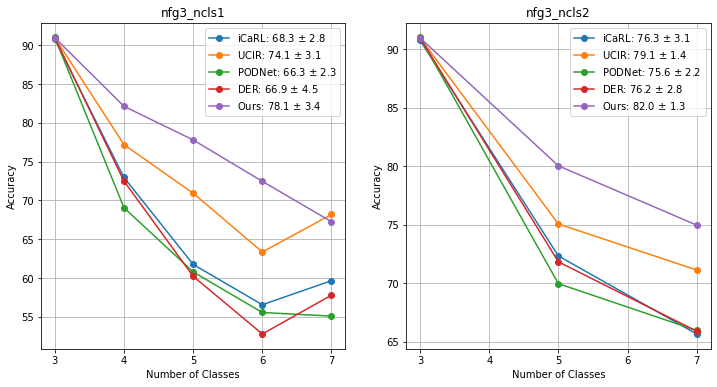

In [7]:
folder = f'results/pretrain'
exps = {
    1:
       {
        'iCaRL': f'{folder}/icarl/20220407_icarl_ham10000_3steps1',
        'UCIR': f'{folder}/ucir/20220407_ucir_ham10000_3steps1',
        'PODNet': f'{folder}/podnet/20220415_podnet_ham10000_3steps1',
        'DER': f'{folder}/der/20220415_derE0_ham10000_3steps1',
        'Ours': f'{folder}/ours/20220406_derE3_ham10000_3steps1',
       },
    2:
       {
        'iCaRL': f'{folder}/icarl/20220404_icarl_ham10000_3steps2',
        'UCIR': f'{folder}/ucir/20220404_ucir_ham10000_3steps2',
        'PODNet': f'{folder}/podnet/20220406_podnet_ham10000_3steps2',
        'DER': f'{folder}/der/20220405_derE0_ham10000_3steps2',
        'Ours': f'{folder}/ours/20220404_derE3_ham10000_3steps2',
       },
      }

incs=[1,2]
row = min(len(incs),3)
plt.figure(figsize=(6*len(incs),6))
for j, inc in enumerate(incs):
    print(f'Incremental class per step: {inc}')
    exp = exps[inc]
    plt.subplot(int(np.ceil(len(incs)//row)),row,j+1)

    avg_top1_total = {}
    cul_top1_total = {}
    count = {}
    for k in [0,1,2]:
        for e1, e2 in exp.items():
            file = f'{e2}/run_{k}_1993_.json'
            if not os.path.exists(file):
#                 file = f'{e2}/run_{k}_199_.json'
#                 if not os.path.exists(file):
                continue
            result = json.load(open(file))

            top1_total = list(map(lambda x: 100 * x['accuracy']['total'], result['results']))
        
            if e1 in avg_top1_total:
                avg_top1_total[e1] += np.array(top1_total)
                cul_top1_total[e1].append(np.mean(top1_total))
                count[e1] += 1
            else:
                avg_top1_total[e1] = np.array(top1_total)
                cul_top1_total[e1] = [np.mean(top1_total)]
                count[e1] = 1
        
    xs = list(range(3,8,inc))
    for e1, e2 in avg_top1_total.items():
        top1_total = e2/count[e1]
        mean = statistics.mean(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else cul_top1_total[e1][0]
        std = statistics.stdev(cul_top1_total[e1]) if len(cul_top1_total[e1])>1 else 0
        if e1 != 'Ours':
            print(f"\t {e1}: {stats.ttest_rel(cul_top1_total['Ours'], cul_top1_total[e1])}")
        plt.plot(xs, top1_total, marker='o', label=f'{e1}: {mean:.1f}' + r' $\pm$ ' + f'{std:.1f}')

    # plt.plot(xs, test)

    plt.xlabel('Number of Classes')
    plt.xticks(list(range(3,8)))
    plt.ylabel('Accuracy')
#     plt.ylim(71,89)
    plt.title(f'nfg3_ncls{inc}')
    plt.grid(True)
    plt.legend()
plt.show()

Forgetting (Table 3)

Incremental class per step: 1
	 iCaRL: Ttest_relResult(statistic=-5.206853701345984, pvalue=0.03496206509751305)
	 UCIR: Ttest_relResult(statistic=-1.2125402466571298, pvalue=0.3490980984680595)
	 PODNet: Ttest_relResult(statistic=-13.268850327483973, pvalue=0.005631868085545486)
	 DER: Ttest_relResult(statistic=-3.594329177050205, pvalue=0.06943857014583653)
Incremental class per step: 2
	 iCaRL: Ttest_relResult(statistic=-1.2904753263247002, pvalue=0.32594805236077506)
	 UCIR: Ttest_relResult(statistic=-1.1297939222803701, pvalue=0.3758363081411078)
	 PODNet: Ttest_relResult(statistic=-10.33154865064468, pvalue=0.00923885020381868)
	 DER: Ttest_relResult(statistic=-2.733086092067914, pvalue=0.1118550813525704)


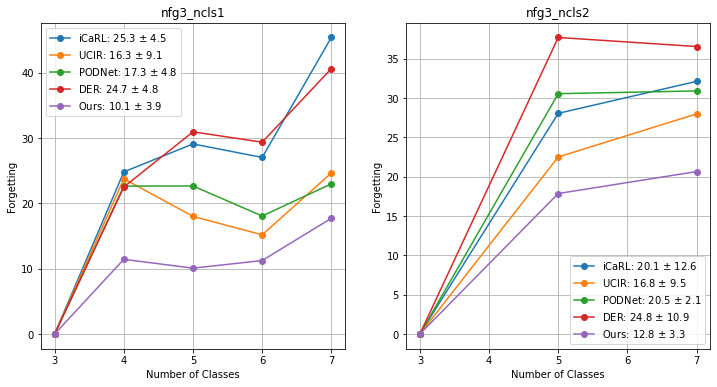

In [8]:
folder = f'results/pretrain'
exps = {
    1:
       {
        'iCaRL': f'{folder}/icarl/20220407_icarl_ham10000_3steps1',
        'UCIR': f'{folder}/ucir/20220407_ucir_ham10000_3steps1',
        'PODNet': f'{folder}/podnet/20220415_podnet_ham10000_3steps1',
        'DER': f'{folder}/der/20220415_derE0_ham10000_3steps1',
        'Ours': f'{folder}/ours/20220406_derE3_ham10000_3steps1',
       },
    2:
       {
        'iCaRL': f'{folder}/icarl/20220404_icarl_ham10000_3steps2',
        'UCIR': f'{folder}/ucir/20220404_ucir_ham10000_3steps2',
        'PODNet': f'{folder}/podnet/20220406_podnet_ham10000_3steps2',
        'DER': f'{folder}/der/20220405_derE0_ham10000_3steps2',
        'Ours': f'{folder}/ours/20220404_derE3_ham10000_3steps2',
       },
      }

incs=[1,2]
row = min(len(incs),3)
plt.figure(figsize=(6*len(incs),6))
for j, inc in enumerate(incs):
    print(f'Incremental class per step: {inc}')
    exp = exps[inc]
    step = int(3//inc)

    plt.subplot(int(np.ceil(len(incs)//row)),row,j+1)

    all_forget = {}
    avg_forget = {}
    count = {}
    for j in [0,1,2]:
        for e1, e2 in exp.items():
            file = f'{e2}/run_{j}_1993_.json'
            if not os.path.exists(file):
                continue
            result = json.load(open(file))
            
            all_forget_total = {}
            for k in range(step,step*2+2):
                if k == step:
                    start = 0
                else:
                    start = (k-1)*inc
                end = k*inc - 1

                top1_first = np.zeros(len(result['results']) - (k-step))
                for p in range(start, end+1):
                    new_key = f'{str(p).zfill(2)}-{str(p).zfill(2)}'
                    top1_first += np.array(list(map(lambda x: x['accuracy_per_class'][new_key], result['results'][(k-step):])))
                top1_first /= (end-start+1) / 100

                forgetting = np.concatenate([[0], np.maximum.accumulate(top1_first)[:-1] - top1_first[1:]])

                if e1 in all_forget_total:
                    all_forget_total[e1][k-step:] += np.array(forgetting)
                else:
                    all_forget_total[e1] = np.array(forgetting)
                    
            forgetting = all_forget_total[e1]        
            forgetting[1:] /= np.arange(len(forgetting)-1) + 1
            if e1 in all_forget:
                all_forget[e1] += forgetting
                avg_forget[e1].append(np.mean(forgetting))
                count[e1] += 1
            else:
                all_forget[e1] = forgetting
                avg_forget[e1] = [np.mean(forgetting)]
                count[e1] = 1
            
    for e1, e2 in all_forget.items():
        forgetting = all_forget[e1]/count[e1]
        mean = statistics.mean(avg_forget[e1]) if len(avg_forget[e1])>1 else avg_forget[e1][0]
        std = statistics.stdev(avg_forget[e1]) if len(avg_forget[e1])>1 else 0
        if e1 != 'Ours':
            print(f"\t {e1}: {stats.ttest_rel(avg_forget['Ours'], avg_forget[e1])}")
        xs = list(range(3,8,inc))
        plt.plot(xs, forgetting, marker='o', label=f'{e1}: {mean:.1f}' + r' $\pm$ ' + f'{std:.1f}')
        
    plt.xlabel('Number of Classes')
    plt.xticks(list(range(3,8)))
    plt.ylabel('Forgetting')
#     plt.ylim(71,89)
    plt.title(f'nfg3_ncls{inc}')
    plt.grid(True)
    plt.legend()

plt.show()
